In [17]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import ElasticNetCV, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR,SVC
from sklearn.linear_model import LinearRegression, ElasticNet,Ridge,Lasso,RidgeClassifierCV,LogisticRegression
from sklearn.model_selection import KFold  
from sklearn.feature_selection import SelectPercentile, f_regression
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
import copy as cp
from sklearn.preprocessing import MaxAbsScaler, Normalizer
from sklearn.svm import LinearSVR
from tpot.builtins import StackingEstimator
from imblearn.under_sampling import NearMiss ,RandomUnderSampler, NeighbourhoodCleaningRule, OneSidedSelection, AllKNN
from imblearn.over_sampling import SMOTE
from xgboost import XGBRegressor
from imblearn.ensemble import EasyEnsemble 
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import roc_curve, auc, precision_score, recall_score
from scipy import interp
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
train = pd.read_csv("../data/processed/train.csv")
test = pd.read_csv("../data/processed/test.csv")
train.pop("id")
test.pop("id")
target = train.pop("血糖")

train_x= train.as_matrix()
train_y = target.as_matrix()
test_x = test.as_matrix()

sns.set()

In [19]:
high_labels = np.zeros((train_y.shape[0],))
for i in range(train_y.shape[0]):
    if train_y[i]<6.68:
        high_labels[i] = 1
    else:
        high_labels[i] = -1
low_labels = np.zeros((train_y.shape[0],))
for i in range(train_y.shape[0]):
    if train_y[i]>3.9:
        low_labels[i] = 1
    else:
        low_labels[i] = -1

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.utils import check_array
from sklearn.preprocessing import OneHotEncoder

class myStackingFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.estimator = None
        
        self.lgb = lgb.LGBMClassifier(boosting_type="GBDT",
                                      num_leaves=31,
                                      learning_rate=0.01,
                                      feature_fraction=0.5,
                                      bagging_fraction=0.5,
                                      bagging_freq=5,
                                      n_estimators=400)
        self.grd_enc = OneHotEncoder()
        self.lr = LogisticRegression()
        self.classes_ = [-1,1]
    def fit(self, X, y=None, **fit_params):
       
        training_features, training_features_lr, training_target, training_target_lr = train_test_split(X, y, test_size=0.5)
        self.lgb.fit(training_features, training_target)
        # fit one-hot编码器
        self.grd_enc.fit(self.lgb.apply(training_features))

        self.lr.fit(self.grd_enc.transform(self.lgb.apply(training_features_lr)), training_target_lr)
    def predict_proba(self, X):
        return self.lr.predict_proba(self.grd_enc.transform(self.lgb.apply(X)))
    def predict(self, X):
        return self.lr.predict(self.grd_enc.transform(self.lgb.apply(X)))


[[ 1.          1.          1.         ...,  0.15105565  0.47621775
   0.09475855]
 [ 1.          1.          0.         ...,  0.03005725  0.47496482
   0.15700775]
 [ 1.          1.          0.         ...,  0.17661483  0.49094618
   0.19039931]
 ..., 
 [ 1.          1.          0.         ...,  0.18889391  0.41400223
   0.16220557]
 [ 1.          1.          0.         ...,  0.20556786  0.37444093
   0.23364226]
 [ 1.          1.          0.         ...,  0.1869879   0.39249266
   0.20813376]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          1.         ...,  0.15105565  0.47621775
   0.09475855]
 [ 1.          1.          0.         ...,  0.03005725  0.47496482
   0.15700775]
 [ 1.          1.          0.         ...,  0.17661483  0.49094618
   0.19039931]
 ..., 
 [ 1.          1.          0.         ...,  0.1704885   0.41103867
   0.0888653 ]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          1.         ...,  0.19296168  0.47230266
   0.10584799]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          1.         ...,  0.15105565  0.47621775
   0.09475855]
 [ 1.          1.          0.         ...,  0.03005725  0.47496482
   0.15700775]
 [ 1.          1.          0.         ...,  0.17661483  0.49094618
   0.19039931]
 ..., 
 [ 1.          1.          0.         ...,  0.28905218  0.47167632
   0.15098548]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          1.         ...,  0.19930937  0.49925569
   0.07681871]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.21731832  0.38284089
   0.1549137 ]
 [ 1.          1.          1.         ...,  0.39405182  0.58237517
   0.14654848]
 [ 1.          1.          1.         ...,  0.25495477  0.4130663
   0.12275716]
 ..., 
 [ 1.          1.          0.         ...,  0.19398863  0.37133139
   0.14003214]
 [ 1.          1.          0.         ...,  0.22569998  0.44679851
   0.13580015]
 [ 1.          1.          1.         ...,  0.22165586  0.47292901
   0.15866283]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.21731832  0.38284089
   0.1549137 ]
 [ 1.          1.          1.         ...,  0.39405182  0.58237517
   0.14654848]
 [ 1.          1.          1.         ...,  0.25495477  0.4130663
   0.12275716]
 ..., 
 [ 1.          1.          0.         ...,  0.17504624  0.43788947
   0.14558212]
 [ 1.          1.          1.         ...,  0.22450211  0.4197752
   0.14045147]
 [ 1.          1.          0.         ...,  0.19735961  0.46337957
   0.165414  ]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.21731832  0.38284089
   0.1549137 ]
 [ 1.          1.          1.         ...,  0.39405182  0.58237517
   0.14654848]
 [ 1.          1.          1.         ...,  0.25495477  0.4130663
   0.12275716]
 ..., 
 [ 1.          1.          0.         ...,  0.11300133  0.43538962
   0.13536035]
 [ 1.          1.          1.         ...,  0.18675099  0.50835324
   0.1164715 ]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.17030462  0.45931095
   0.18279652]
 [ 1.          1.          1.         ...,  0.23108412  0.45367915
   0.12620459]
 [ 1.          1.          0.         ...,  0.2881463   0.39654243
   0.17144324]
 ..., 
 [ 1.          1.          1.         ...,  0.07654823  0.40932323
   0.1736136 ]
 [ 1.          1.          1.         ...,  0.24983021  0.43710822
   0.11833127]
 [ 1.          1.          0.         ...,  0.20264281  0.409947
   0.22900629]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.17030462  0.45931095
   0.18279652]
 [ 1.          1.          1.         ...,  0.23108412  0.45367915
   0.12620459]
 [ 1.          1.          0.         ...,  0.2881463   0.39654243
   0.17144324]
 ..., 
 [ 1.          1.          1.         ...,  0.09832193  0.4421089
   0.07752848]
 [ 1.          1.          0.         ...,  0.11347144  0.37832904
   0.11173952]
 [ 1.          1.          0.         ...,  0.18717114  0.42398942
   0.20283848]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.17030462  0.45931095
   0.18279652]
 [ 1.          1.          1.         ...,  0.23108412  0.45367915
   0.12620459]
 [ 1.          1.          0.         ...,  0.2881463   0.39654243
   0.17144324]
 ..., 
 [ 1.          1.          0.         ...,  0.13363132  0.45258431
   0.12286327]
 [ 1.          1.          0.         ...,  0.21099947  0.3671349
   0.08399514]
 [ 1.          1.          0.         ...,  0.22416142  0.3909354
   0.13080697]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          1.         ...,  0.29733799  0.4424215
   0.15057524]
 [ 1.          1.          0.         ...,  0.15669901  0.52263532
   0.13087776]
 [ 1.          1.          1.         ...,  0.17602067  0.40043768
   0.17961124]
 ..., 
 [ 1.          1.          0.         ...,  0.10013745  0.28343897
   0.11865554]
 [ 1.          1.          1.         ...,  0.13319471  0.40464587
   0.14100964]
 [ 1.          1.          0.         ...,  0.2142407   0.36200803
   0.13504751]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          1.         ...,  0.29733799  0.4424215
   0.15057524]
 [ 1.          1.          0.         ...,  0.15669901  0.52263532
   0.13087776]
 [ 1.          1.          1.         ...,  0.17602067  0.40043768
   0.17961124]
 ..., 
 [ 1.          1.          0.         ...,  0.13614608  0.43788947
   0.16294573]
 [ 1.          1.          0.         ...,  0.18964087  0.42383332
   0.11213956]
 [ 1.          1.          0.         ...,  0.18749438  0.38470837
   0.1364215 ]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          1.         ...,  0.29733799  0.4424215
   0.15057524]
 [ 1.          1.          0.         ...,  0.15669901  0.52263532
   0.13087776]
 [ 1.          1.          1.         ...,  0.17602067  0.40043768
   0.17961124]
 ..., 
 [ 1.          1.          0.         ...,  0.1250637   0.40152856
   0.11625238]
 [ 1.          1.          0.         ...,  0.28452586  0.42929799
   0.14342982]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.17836214  0.41259836
   0.11342577]
 [ 1.          1.          0.         ...,  0.22761115  0.41743452
   0.19217471]
 [ 1.          1.          0.         ...,  0.18436912  0.43117207
   0.1445968 ]
 ..., 
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          1.         ...,  0.13412564  0.45743347
   0.09226962]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.17836214  0.41259836
   0.11342577]
 [ 1.          1.          0.         ...,  0.22761115  0.41743452
   0.19217471]
 [ 1.          1.          0.         ...,  0.18436912  0.43117207
   0.1445968 ]
 ..., 
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          1.         ...,  0.29063023  0.45633837
   0.16642386]
 [ 1.          1.          1.         ...,  0.12837306  0.4102589
   0.12149851]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.17836214  0.41259836
   0.11342577]
 [ 1.          1.          0.         ...,  0.22761115  0.41743452
   0.19217471]
 [ 1.          1.          0.         ...,  0.18436912  0.43117207
   0.1445968 ]
 ..., 
 [ 1.          1.          1.         ...,  0.17608536  0.53755559
   0.1613492 ]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.30272923  0.39732139
   0.13656083]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.24142199  0.45289711
   0.18358934]
 [ 1.          1.          1.         ...,  0.23485105  0.47371199
   0.19107674]
 [-1.          1.          1.         ...,  1.          0.0802465
   0.12896995]
 ..., 
 [ 1.          1.          1.         ...,  0.07787029  0.38470837
   0.09397075]
 [ 1.          1.          0.         ...,  0.18127624  0.39747718
   0.13177122]
 [ 1.          1.          1.         ...,  0.15532578  0.44664217
   0.10630176]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.24142199  0.45289711
   0.18358934]
 [ 1.          1.          1.         ...,  0.23485105  0.47371199
   0.19107674]
 [-1.          1.          1.         ...,  1.          0.0802465
   0.12896995]
 ..., 
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.14061765  0.45790282
   0.22639338]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.24142199  0.45289711
   0.18358934]
 [ 1.          1.          1.         ...,  0.23485105  0.47371199
   0.19107674]
 [-1.          1.          1.         ...,  1.          0.0802465
   0.12896995]
 ..., 
 [ 1.          1.          1.         ...,  0.15976927  0.41275434
   0.1329656 ]
 [ 1.          1.          0.         ...,  0.22585785  0.38299651
   0.10562266]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          1.         ...,  0.23759568  0.41244238
   0.12070525]
 [ 1.          1.          1.         ...,  0.32320382  0.50505881
   0.08678717]
 ..., 
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          1.         ...,  0.13138325  0.39000114
   0.08322506]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          1.         ...,  0.23759568  0.41244238
   0.12070525]
 [ 1.          1.          1.         ...,  0.32320382  0.50505881
   0.08678717]
 ..., 
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          1.         ...,  0.23759568  0.41244238
   0.12070525]
 [ 1.          1.          1.         ...,  0.32320382  0.50505881
   0.08678717]
 ..., 
 [ 1.          1.          0.         ...,  0.15048478  0.35672838
   0.12989255]
 [ 1.          1.          0.         ...,  0.22785603  0.45274071
   0.14461459]
 [ 1.          1.          0.         ...,  0.28077863  0.4961196
   0.1323797 ]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.22213127  0.41634233
   0.19481167]
 [ 1.          1.          0.         ...,  0.24200338  0.47825394
   0.13505574]
 ..., 
 [ 1.          1.          0.         ...,  0.18320257  0.40199611
   0.11177048]
 [ 1.          1.          0.         ...,  0.14064628  0.54415517
   0.14131364]
 [ 1.          1.          0.         ...,  0.24973558  0.43429606
   0.16370855]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.22213127  0.41634233
   0.19481167]
 [ 1.          1.          0.         ...,  0.24200338  0.47825394
   0.13505574]
 ..., 
 [ 1.          1.          1.         ...,  0.14526627  0.44883112
   0.12336079]
 [ 1.          1.          1.         ...,  0.17818336  0.47856722
   0.10191907]
 [ 1.          1.          0.         ...,  0.24567613  0.52593258
   0.16739149]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.22213127  0.41634233
   0.19481167]
 [ 1.          1.          0.         ...,  0.24200338  0.47825394
   0.13505574]
 ..., 
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.16810941  0.42336502
   0.23691598]
 [ 1.          1.          0.         ...,  0.14299414  0.43538962
   0.204965  ]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          1.         ...,  0.18555923  0.58174556
   0.15663638]
 [ 1.          1.          1.         ...,  0.18675099  0.4926705
   0.19271949]
 [ 1.          1.          1.         ...,  0.24954223  0.51102055
   0.13887809]
 ..., 
 [ 1.          1.          0.         ...,  0.26122039  0.49737398
   0.12879654]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          1.         ...,  0.18555923  0.58174556
   0.15663638]
 [ 1.          1.          1.         ...,  0.18675099  0.4926705
   0.19271949]
 [ 1.          1.          1.         ...,  0.24954223  0.51102055
   0.13887809]
 ..., 
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.11769702  0.37086504
   0.09307529]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          1.         ...,  0.18555923  0.58174556
   0.15663638]
 [ 1.          1.          1.         ...,  0.18675099  0.4926705
   0.19271949]
 [ 1.          1.          1.         ...,  0.24954223  0.51102055
   0.13887809]
 ..., 
 [ 1.          1.          0.         ...,  0.19483232  0.47026716
   0.10453892]
 [ 1.          1.          1.         ...,  0.25065871  0.52593258
   0.15962503]
 [ 1.          1.          0.         ...,  0.18740558  0.50145126
   0.13665561]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          1.         ...,  0.2193362   0.50098076
   0.18395762]
 [ 1.          1.          0.         ...,  0.15551646  0.4696409
   0.12767978]
 [ 1.          1.          1.         ...,  0.1881788   0.44101486
   0.10995865]
 ..., 
 [ 1.          1.          1.         ...,  0.17312499  0.43929581
   0.0999262 ]
 [ 1.          1.          1.         ...,  0.11303301  0.41213043
   0.15102813]
 [ 1.          1.          0.         ...,  0.20244381  0.5011376
   0.16679659]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          1.         ...,  0.2193362   0.50098076
   0.18395762]
 [ 1.          1.          0.         ...,  0.15551646  0.4696409
   0.12767978]
 [ 1.          1.          1.         ...,  0.1881788   0.44101486
   0.10995865]
 ..., 
 [ 1.          1.          1.         ...,  0.18127624  0.46588382
   0.13645393]
 [ 1.          1.          1.         ...,  0.35737771  0.44664217
   0.15105474]
 [ 1.          1.          1.         ...,  0.18127624  0.391714
   0.07332285]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          1.         ...,  0.2193362   0.50098076
   0.18395762]
 [ 1.          1.          0.         ...,  0.15551646  0.4696409
   0.12767978]
 [ 1.          1.          1.         ...,  0.1881788   0.44101486
   0.10995865]
 ..., 
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.17354809  0.42804874
   0.13548712]
 [ 1.          1.          1.         ...,  0.18127624  0.4780973
   0.09138211]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          1.         ...,  0.15105565  0.47621775
   0.09475855]
 [ 1.          1.          0.         ...,  0.30375473  0.39031256
   0.12953939]
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 ..., 
 [ 1.          1.          0.         ...,  0.16891207  0.43554584
   0.12900696]
 [ 1.          1.          1.         ...,  0.17941622  0.39280413
   0.1974103 ]
 [ 1.          1.          0.         ...,  0.1937349   0.39202546
   0.12052763]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          1.         ...,  0.15105565  0.47621775
   0.09475855]
 [ 1.          1.          0.         ...,  0.30375473  0.39031256
   0.12953939]
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 ..., 
 [ 1.          1.          0.         ...,  0.19959781  0.41571827
   0.12720246]
 [ 1.          1.          1.         ...,  0.20032315  0.40760801
   0.09637948]
 [ 1.          1.          1.         ...,  0.12967576  0.4832671
   0.2167529 ]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          1.         ...,  0.15105565  0.47621775
   0.09475855]
 [ 1.          1.          0.         ...,  0.30375473  0.39031256
   0.12953939]
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 ..., 
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.2607525   0.50443136
   0.19010267]
 [ 1.          1.          1.         ...,  0.22116509  0.40791985
   0.10596098]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.21731832  0.38284089
   0.1549137 ]
 [ 1.          1.          1.         ...,  0.25495477  0.4130663
   0.12275716]
 [ 1.          1.          0.         ...,  0.19802048  0.41759055
   0.14164884]
 ..., 
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.1864698   0.42820489
   0.11878136]
 [ 1.          1.          1.         ...,  0.14352772  0.44851839
   0.13785107]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.21731832  0.38284089
   0.1549137 ]
 [ 1.          1.          1.         ...,  0.25495477  0.4130663
   0.12275716]
 [ 1.          1.          0.         ...,  0.19802048  0.41759055
   0.14164884]
 ..., 
 [ 1.          1.          0.         ...,  0.29588362  0.4640056
   0.13787288]
 [ 1.          1.          1.         ...,  0.16324486  0.42383332
   0.09828878]
 [ 1.          1.          0.         ...,  0.2677998   0.52310632
   0.13102488]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.21731832  0.38284089
   0.1549137 ]
 [ 1.          1.          1.         ...,  0.25495477  0.4130663
   0.12275716]
 [ 1.          1.          0.         ...,  0.19802048  0.41759055
   0.14164884]
 ..., 
 [ 1.          1.          1.         ...,  0.12774558  0.36962152
   0.10484543]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.17030462  0.45931095
   0.18279652]
 [ 1.          1.          1.         ...,  0.23108412  0.45367915
   0.12620459]
 [ 1.          1.          0.         ...,  0.15035479  0.54274081
   0.26673043]
 ..., 
 [ 1.          1.          1.         ...,  0.15980485  0.39482891
   0.1127371 ]
 [ 1.          1.          0.         ...,  0.15281029  0.498158
   0.15243791]
 [ 1.          1.          1.         ...,  0.17968556  0.39482891
   0.10493531]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.17030462  0.45931095
   0.18279652]
 [ 1.          1.          1.         ...,  0.23108412  0.45367915
   0.12620459]
 [ 1.          1.          0.         ...,  0.15035479  0.54274081
   0.26673043]
 ..., 
 [ 1.          1.          1.         ...,  0.23092761  0.5855235
   0.12425592]
 [ 1.          1.          1.         ...,  0.06393104  0.4263312
   0.11133323]
 [ 1.          1.          0.         ...,  0.23269442  0.45242791
   0.1040262 ]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.17030462  0.45931095
   0.18279652]
 [ 1.          1.          1.         ...,  0.23108412  0.45367915
   0.12620459]
 [ 1.          1.          0.         ...,  0.15035479  0.54274081
   0.26673043]
 ..., 
 [ 1.          1.          1.         ...,  0.15531813  0.430235
   0.11392197]
 [ 1.          1.          1.         ...,  0.14148446  0.35300318
   0.24065056]
 [ 1.          1.          0.         ...,  0.17744252  0.38221847
   0.08663751]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          1.         ...,  0.29733799  0.4424215
   0.15057524]
 [ 1.          1.          1.         ...,  0.17602067  0.40043768
   0.17961124]
 [ 1.          1.          0.         ...,  0.14064628  0.52954447
   0.09827407]
 ..., 
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.17581139  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.10723397  0.45743347
   0.14642273]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1]
[[ 1.          1.          1.         ...,  0.29733799  0.4424215
   0.15057524]
 [ 1.          1.          1.         ...,  0.17602067  0.40043768
   0.17961124]
 [ 1.          1.          0.         ...,  0.14064628  0.52954447
   0.09827407]
 ..., 
 [ 1.          1.          0.         ...,  0.16967794  0.46416211
   0.13380385]
 [ 1.          1.          0.         ...,  0.15183767  0.45805928
   0.13855011]
 [ 1.          1.          0.         ...,  0.16309565  0.44351563
   0.15725754]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1]
[[ 1.          1.          1.         ...,  0.29733799  0.4424215
   0.15057524]
 [ 1.          1.          1.         ...,  0.17602067  0.40043768
   0.17961124]
 [ 1.          1.          0.         ...,  0.14064628  0.52954447
   0.09827407]
 ..., 
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.22901017  0.38751014
   0.14456817]
 [ 1.          1.          0.         ...,  0.22319541  0.50694127
   0.16763539]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.17836214  0.41259836
   0.11342577]
 [ 1.          1.          0.         ...,  0.18436912  0.43117207
   0.1445968 ]
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 ..., 
 [ 1.          1.          0.         ...,  0.20696717  0.43226539
   0.11849937]
 [ 1.          1.          1.         ...,  0.22529149  0.45195871
   0.13724248]
 [ 1.          1.          1.         ...,  0.25137412  0.47214607
   0.13941116]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.17836214  0.41259836
   0.11342577]
 [ 1.          1.          0.         ...,  0.18436912  0.43117207
   0.1445968 ]
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 ..., 
 [ 1.          1.          0.         ...,  0.1757229   0.42882951
   0.18480593]
 [ 1.          1.          1.         ...,  0.17986028  0.45430481
   0.08467193]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.17836214  0.41259836
   0.11342577]
 [ 1.          1.          0.         ...,  0.18436912  0.43117207
   0.1445968 ]
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 ..., 
 [ 1.          1.          1.         ...,  0.15630297  0.42211628
   0.0840832 ]
 [ 1.          1.          0.         ...,  0.16909487  0.38533093
   0.11846234]
 [ 1.          1.          0.         ...,  0.20321703  0.38050696
   0.14195645]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.24142199  0.45289711
   0.18358934]
 [-1.          1.          1.         ...,  1.          0.0802465
   0.12896995]
 [ 1.          1.          0.         ...,  0.09349611  0.63373866
   0.21266928]
 ..., 
 [ 1.          1.          0.         ...,  0.11032685  0.38066254
   0.14391104]
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.24142199  0.45289711
   0.18358934]
 [-1.          1.          1.         ...,  1.          0.0802465
   0.12896995]
 [ 1.          1.          0.         ...,  0.09349611  0.63373866
   0.21266928]
 ..., 
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.24142199  0.45289711
   0.18358934]
 [-1.          1.          1.         ...,  1.          0.0802465
   0.12896995]
 [ 1.          1.          0.         ...,  0.09349611  0.63373866
   0.21266928]
 ..., 
 [ 1.          1.          1.         ...,  0.2205112   0.55028509
   0.16308724]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          1.         ...,  0.15493055  0.39576353
   0.09838025]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          1.         ...,  0.23759568  0.41244238
   0.12070525]
 [ 1.          1.          1.         ...,  0.32320382  0.50505881
   0.08678717]
 ..., 
 [ 1.          1.          1.         ...,  0.18802952  0.43632701
   0.07310777]
 [ 1.          1.          1.         ...,  0.13432666  0.47245924
   0.12385861]
 [ 1.          1.          1.         ...,  0.26056066  0.43398363
   0.13546549]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          1.         ...,  0.23759568  0.41244238
   0.12070525]
 [ 1.          1.          1.         ...,  0.32320382  0.50505881
   0.08678717]
 ..., 
 [ 1.          1.          1.         ...,  0.14971741  0.4182147
   0.07354079]
 [ 1.          1.          0.         ...,  0.14029182  0.4219602
   0.14842657]
 [ 1.          1.          1.         ...,  0.13159641  0.44180138
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          1.         ...,  0.23759568  0.41244238
   0.12070525]
 [ 1.          1.          1.         ...,  0.32320382  0.50505881
   0.08678717]
 ..., 
 [ 1.          1.          0.         ...,  0.21367703  0.4102589
   0.10734053]
 [ 1.          1.          0.         ...,  0.3538273   0.4160303
   0.14785778]
 [ 1.          1.          0.         ...,  0.14991341  0.57922724
   0.14597154]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.22213127  0.41634233
   0.19481167]
 [ 1.          1.          0.         ...,  0.24200338  0.47825394
   0.13505574]
 ..., 
 [ 1.          1.          1.         ...,  0.1441775   0.48358047
   0.1083775 ]
 [ 1.          1.          0.         ...,  0.23250003  0.41150656
   0.11748851]
 [ 1.          1.          0.         ...,  0.24391848  0.44570414
   0.18632631]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.22213127  0.41634233
   0.19481167]
 [ 1.          1.          0.         ...,  0.24200338  0.47825394
   0.13505574]
 ..., 
 [ 1.          1.          0.         ...,  0.09550893  0.41275434
   0.12193361]
 [ 1.          1.          1.         ...,  0.24842816  0.47935045
   0.11847933]
 [ 1.          1.          1.         ...,  0.1258365   0.38284089
   0.09130356]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.22213127  0.41634233
   0.19481167]
 [ 1.          1.          0.         ...,  0.24200338  0.47825394
   0.13505574]
 ..., 
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.20167059  0.54556962
   0.18039259]
 [ 1.          1.          0.         ...,  0.11877261  0.47559128
   0.12933166]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          1.         ...,  0.18555923  0.58174556
   0.15663638]
 [ 1.          1.          1.         ...,  0.18675099  0.4926705
   0.19271949]
 [ 1.          1.          1.         ...,  0.24954223  0.51102055
   0.13887809]
 ..., 
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          1.         ...,  0.15055641  0.54368371
   0.14453625]
 [ 1.          1.          0.         ...,  0.25738177  0.33192016
   0.13079236]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          1.         ...,  0.18555923  0.58174556
   0.15663638]
 [ 1.          1.          1.         ...,  0.18675099  0.4926705
   0.19271949]
 [ 1.          1.          1.         ...,  0.24954223  0.51102055
   0.13887809]
 ..., 
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.15161048  0.43788947
   0.09799948]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          1.         ...,  0.18555923  0.58174556
   0.15663638]
 [ 1.          1.          1.         ...,  0.18675099  0.4926705
   0.19271949]
 [ 1.          1.          1.         ...,  0.24954223  0.51102055
   0.13887809]
 ..., 
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          1.         ...,  0.1676647   0.35936787
   0.13420291]
 [ 1.          1.          1.         ...,  0.16980277  0.4856175
   0.0744146 ]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.18127624  0.45164593
   0.12601307]
 [ 1.          1.          1.         ...,  0.2193362   0.50098076
   0.18395762]
 [ 1.          1.          0.         ...,  0.15551646  0.4696409
   0.12767978]
 ..., 
 [ 1.          1.          0.         ...,  0.1583013   0.53928386
   0.18747659]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.18127624  0.45164593
   0.12601307]
 [ 1.          1.          1.         ...,  0.2193362   0.50098076
   0.18395762]
 [ 1.          1.          0.         ...,  0.15551646  0.4696409
   0.12767978]
 ..., 
 [ 1.          1.          1.         ...,  0.16588949  0.50505881
   0.15089537]
 [ 1.          1.          1.         ...,  0.1619048   0.43070353
   0.12687716]
 [ 1.          1.          0.         ...,  0.15821698  0.53001563
   0.11563642]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.18127624  0.45164593
   0.12601307]
 [ 1.          1.          1.         ...,  0.2193362   0.50098076
   0.18395762]
 [ 1.          1.          0.         ...,  0.15551646  0.4696409
   0.12767978]
 ..., 
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.21948582  0.38595352
   0.12449492]
 [ 1.          1.          0.         ...,  0.17542185  0.38315212
   0.09979561]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.12947785  0.42570669
   0.18910706]
 [ 1.          1.          1.         ...,  0.17602067  0.40043768
   0.24077965]
 [ 1.          1.          1.         ...,  0.13951779  0.48890856
   0.23897199]
 ..., 
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.17157813]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.17157813]
 [ 1.          1.          1.         ...,  0.13907927  0.44398457
   0.16409826]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1]
[[ 1.          1.          0.         ...,  0.12947785  0.42570669
   0.18910706]
 [ 1.          1.          1.         ...,  0.17602067  0.40043768
   0.24077965]
 [ 1.          1.          1.         ...,  0.13951779  0.48890856
   0.23897199]
 ..., 
 [ 1.          1.          1.         ...,  0.1324168   0.55154271
   0.12974211]
 [ 1.          1.          0.         ...,  0.19829752  0.46572729
   0.19614419]
 [ 1.          1.          0.         ...,  0.24175347  0.46228407
   0.17594188]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1]
[[ 1.          1.          0.         ...,  0.12947785  0.42570669
   0.18910706]
 [ 1.          1.          1.         ...,  0.17602067  0.40043768
   0.24077965]
 [ 1.          1.          1.         ...,  0.13951779  0.48890856
   0.23897199]
 ..., 
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.17157813]
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.17157813]
 [ 1.          1.          1.         ...,  0.24304368  0.35021017
   0.17676088]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.17661483  0.49094618
   0.25524172]
 [ 1.          1.          1.         ...,  0.18675099  0.4926705
   0.25835206]
 [ 1.          1.          1.         ...,  0.20305688  0.40293126
   0.2278409 ]
 ..., 
 [ 1.          1.          1.         ...,  0.07298476  0.46478816
   0.11703132]
 [ 1.          1.          1.         ...,  0.19360997  0.48655774
   0.14790583]
 [ 1.          1.          0.         ...,  0.16689148  0.39638665
   0.21469417]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.17661483  0.49094618
   0.25524172]
 [ 1.          1.          1.         ...,  0.18675099  0.4926705
   0.25835206]
 [ 1.          1.          1.         ...,  0.20305688  0.40293126
   0.2278409 ]
 ..., 
 [ 1.          1.          0.         ...,  0.13052082  0.38144048
   0.24140877]
 [ 1.          1.          1.         ...,  0.21440984  0.41930703
   0.12863455]
 [ 1.          1.          1.         ...,  0.19828708  0.4102589
   0.15378117]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.17661483  0.49094618
   0.25524172]
 [ 1.          1.          1.         ...,  0.18675099  0.4926705
   0.25835206]
 [ 1.          1.          1.         ...,  0.20305688  0.40293126
   0.2278409 ]
 ..., 
 [ 1.          1.          1.         ...,  0.12030325  0.42570669
   0.12772882]
 [ 1.          1.          1.         ...,  0.3582202   0.45117676
   0.24735109]
 [ 1.          1.          0.         ...,  0.18127624  0.37288605
   0.16940723]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.15435088  0.51918159
   0.16667245]
 [ 1.          1.          0.         ...,  0.30559439  0.42945416
   0.2175538 ]
 [ 1.          1.          0.         ...,  0.15035479  0.54274081
   0.35756817]
 ..., 
 [ 1.          1.          0.         ...,  0.17437946  0.38922265
   0.18971065]
 [ 1.          1.          0.         ...,  0.10732759  0.5576746
   0.13310147]
 [ 1.          1.          1.         ...,  0.12682944  0.38595352
   0.19367597]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.15435088  0.51918159
   0.16667245]
 [ 1.          1.          0.         ...,  0.30559439  0.42945416
   0.2175538 ]
 [ 1.          1.          0.         ...,  0.15035479  0.54274081
   0.35756817]
 ..., 
 [ 1.          1.          0.         ...,  0.18003622  0.47277242
   0.22338772]
 [ 1.          1.          1.         ...,  0.13281092  0.41556225
   0.13728547]
 [ 1.          1.          1.         ...,  0.18054037  0.52499045
   0.25181539]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.15435088  0.51918159
   0.16667245]
 [ 1.          1.          0.         ...,  0.30559439  0.42945416
   0.2175538 ]
 [ 1.          1.          0.         ...,  0.15035479  0.54274081
   0.35756817]
 ..., 
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.17157813]
 [ 1.          1.          0.         ...,  0.14781824  0.3871988
   0.17237329]
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.17157813]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.26704459  0.44180138
   0.17157813]
 [-1.          1.          0.         ...,  0.56313084  0.48922203
   0.15606902]
 [ 1.          1.          1.         ...,  0.34362987  0.45148954
   0.23398075]
 ..., 
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.17157813]
 [ 1.          1.          1.         ...,  0.15302127  0.45117676
   0.17131919]
 [ 1.          1.          0.         ...,  0.22496222  0.44804932
   0.39443973]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1]
[[ 1.          1.          0.         ...,  0.26704459  0.44180138
   0.17157813]
 [-1.          1.          0.         ...,  0.56313084  0.48922203
   0.15606902]
 [ 1.          1.          1.         ...,  0.34362987  0.45148954
   0.23398075]
 ..., 
 [ 1.          1.          1.         ...,  0.17067282  0.51400209
   0.16614193]
 [ 1.          1.          1.         ...,  0.16733758  0.44601681
   0.17298293]
 [ 1.          1.          1.         ...,  0.17408162  0.43367121
   0.13669005]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1]
[[ 1.          1.          0.         ...,  0.26704459  0.44180138
   0.17157813]
 [-1.          1.          0.         ...,  0.56313084  0.48922203
   0.15606902]
 [ 1.          1.          1.         ...,  0.34362987  0.45148954
   0.23398075]
 ..., 
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.17157813]
 [ 1.          1.          1.         ...,  0.18127624  0.31722159
   0.13352737]
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.17157813]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.18190866  0.47888051
   0.19862851]
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.17157813]
 [ 1.          1.          0.         ...,  0.19230726  0.46650994
   0.19616708]
 ..., 
 [ 1.          1.          1.         ...,  0.14585068  0.47136316
   0.12341713]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.17157813]
 [ 1.          1.          0.         ...,  0.22907373  0.45743347
   0.20060987]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.18190866  0.47888051
   0.19862851]
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.17157813]
 [ 1.          1.          0.         ...,  0.19230726  0.46650994
   0.19616708]
 ..., 
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.17157813]
 [ 1.          1.          0.         ...,  0.23902874  0.36247401
   0.20021718]
 [ 1.          1.          1.         ...,  0.19664015  0.43179682
   0.10883126]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.18190866  0.47888051
   0.19862851]
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.17157813]
 [ 1.          1.          0.         ...,  0.19230726  0.46650994
   0.19616708]
 ..., 
 [ 1.          1.          0.         ...,  0.13756098  0.37164231
   0.23722727]
 [ 1.          1.          0.         ...,  0.18809951  0.52514747
   0.17164314]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.17157813]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.12449116  0.46337957
   0.18068088]
 [ 1.          1.          0.         ...,  0.03387834  0.40729617
   0.22767127]
 [ 1.          1.          0.         ...,  0.25171789  0.44179631
   0.25756516]
 ..., 
 [ 1.          1.          0.         ...,  0.14010183  0.36418277
   0.19433209]
 [ 1.          1.          0.         ...,  0.25930718  0.44773661
   0.18891469]
 [ 1.          1.          0.         ...,  0.24263413  0.48687117
   0.16934794]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.12449116  0.46337957
   0.18068088]
 [ 1.          1.          0.         ...,  0.03387834  0.40729617
   0.22767127]
 [ 1.          1.          0.         ...,  0.25171789  0.44179631
   0.25756516]
 ..., 
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.17157813]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.17157813]
 [ 1.          1.          0.         ...,  0.24191878  0.4851474
   0.23028552]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.12449116  0.46337957
   0.18068088]
 [ 1.          1.          0.         ...,  0.03387834  0.40729617
   0.22767127]
 [ 1.          1.          0.         ...,  0.25171789  0.44179631
   0.25756516]
 ..., 
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.17157813]
 [ 1.          1.          0.         ...,  0.13930853  0.46056273
   0.15122558]
 [ 1.          1.          1.         ...,  0.15768532  0.47966375
   0.1313422 ]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.17157813]
 [ 1.          1.          0.         ...,  0.15291464  0.43538962
   0.13519455]
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.17157813]
 ..., 
 [ 1.          1.          1.         ...,  0.0932655   0.37490743
   0.14825912]
 [ 1.          1.          1.         ...,  0.21542484  0.43398363
   0.16628332]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.17157813]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.17157813]
 [ 1.          1.          0.         ...,  0.15291464  0.43538962
   0.13519455]
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.17157813]
 ..., 
 [ 1.          1.          0.         ...,  0.30560599  0.32433571
   0.26133507]
 [ 1.          1.          1.         ...,  0.13735967  0.51667015
   0.20638822]
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.17157813]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.17157813]
 [ 1.          1.          0.         ...,  0.15291464  0.43538962
   0.13519455]
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.17157813]
 ..., 
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.17157813]
 [ 1.          1.          0.         ...,  0.13306457  0.43132825
   0.20207196]
 [ 1.          1.          1.         ...,  0.33468023  0.46901466
   0.18848244]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          1.         ...,  0.20975975  0.58190296
   0.14194455]
 [ 1.          1.          0.         ...,  0.11444418  0.4333588
   0.36171925]
 [ 1.          1.          0.         ...,  0.11444418  0.4333588
   0.36171925]
 ..., 
 [ 1.          1.          1.         ...,  0.21227101  0.4856175
   0.23647507]
 [ 1.          1.          0.         ...,  0.1325792   0.33207501
   0.1457451 ]
 [ 1.          1.          1.         ...,  0.17515268  0.47277242
   0.11170708]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          1.         ...,  0.20975975  0.58190296
   0.14194455]
 [ 1.          1.          0.         ...,  0.11444418  0.4333588
   0.36171925]
 [ 1.          1.          0.         ...,  0.11444418  0.4333588
   0.36171925]
 ..., 
 [ 1.          1.          1.         ...,  0.11303301  0.41213043
   0.20246229]
 [ 1.          1.          1.         ...,  0.194202    0.48671446
   0.15693137]
 [ 1.          1.          1.         ...,  0.14797157  0.47590451
   0.20600146]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          1.         ...,  0.20975975  0.58190296
   0.14194455]
 [ 1.          1.          0.         ...,  0.11444418  0.4333588
   0.36171925]
 [ 1.          1.          0.         ...,  0.11444418  0.4333588
   0.36171925]
 ..., 
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.17157813]
 [ 1.          1.          0.         ...,  0.20855495  0.44695486
   0.28517318]
 [ 1.          1.          1.         ...,  0.23217652  0.57308989
   0.13665249]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          1.         ...,  0.24954223  0.51102055
   0.18617443]
 [ 1.          1.          0.         ...,  0.29230964  0.38439711
   0.14941427]
 [ 1.          1.          0.         ...,  0.24748622  0.41946309
   0.17679011]
 ..., 
 [ 1.          1.          1.         ...,  0.16916495  0.43773321
   0.13721265]
 [ 1.          1.          0.         ...,  0.10704666  0.57010044
   0.22686127]
 [ 1.          1.          1.         ...,  0.22121709  0.4267996
   0.19076672]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          1.         ...,  0.24954223  0.51102055
   0.18617443]
 [ 1.          1.          0.         ...,  0.29230964  0.38439711
   0.14941427]
 [ 1.          1.          0.         ...,  0.24748622  0.41946309
   0.17679011]
 ..., 
 [ 1.          1.          1.         ...,  0.19187365  0.61860341
   0.23889104]
 [ 1.          1.          1.         ...,  0.23653294  0.37988466
   0.17224861]
 [ 1.          1.          0.         ...,  0.13797216  0.45946742
   0.12360954]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          1.         ...,  0.24954223  0.51102055
   0.18617443]
 [ 1.          1.          0.         ...,  0.29230964  0.38439711
   0.14941427]
 [ 1.          1.          0.         ...,  0.24748622  0.41946309
   0.17679011]
 ..., 
 [ 1.          1.          1.         ...,  0.31896686  0.50051028
   0.14872447]
 [ 1.          1.          0.         ...,  0.32093135  0.43710822
   0.22206945]
 [ 1.          1.          0.         ...,  0.3224306   0.3811293
   0.13413476]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.18127624  0.45164593
   0.16892809]
 [ 1.          1.          0.         ...,  0.14758593  0.47606113
   0.33633464]
 [ 1.          1.          0.         ...,  0.19947164  0.61513604
   0.20327069]
 ..., 
 [ 1.          1.          1.         ...,  0.18723433  0.42773645
   0.14228769]
 [ 1.          1.          0.         ...,  0.15010011  0.35890203
   0.14992317]
 [ 1.          1.          0.         ...,  0.22429256  0.4219602
   0.20692312]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.18127624  0.45164593
   0.16892809]
 [ 1.          1.          0.         ...,  0.14758593  0.47606113
   0.33633464]
 [ 1.          1.          0.         ...,  0.19947164  0.61513604
   0.20327069]
 ..., 
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.17157813]
 [ 1.          1.          1.         ...,  0.28861168  0.4449225
   0.15137122]
 [ 1.          1.          0.         ...,  0.11569449  0.7354542
   0.37293095]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.18127624  0.45164593
   0.16892809]
 [ 1.          1.          0.         ...,  0.14758593  0.47606113
   0.33633464]
 [ 1.          1.          0.         ...,  0.19947164  0.61513604
   0.20327069]
 ..., 
 [ 1.          1.          0.         ...,  0.0527918   0.49078944
   0.24810333]
 [ 1.          1.          0.         ...,  0.2188686   0.52122236
   0.16930446]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.17157813]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.12947785  0.42570669
   0.14106571]
 [ 1.          1.          0.         ...,  0.1578701   0.41369024
   0.1239817 ]
 [ 1.          1.          1.         ...,  0.13951779  0.48890856
   0.1782628 ]
 ..., 
 [ 1.          1.          1.         ...,  0.11753218  0.54399802
   0.11712763]
 [ 1.          1.          0.         ...,  0.17908142  0.36231868
   0.15000856]
 [ 1.          1.          0.         ...,  0.12539057  0.37102049
   0.13325652]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.12947785  0.42570669
   0.14106571]
 [ 1.          1.          0.         ...,  0.1578701   0.41369024
   0.1239817 ]
 [ 1.          1.          1.         ...,  0.13951779  0.48890856
   0.1782628 ]
 ..., 
 [ 1.          1.          1.         ...,  0.12085831  0.46760571
   0.07086483]
 [ 1.          1.          1.         ...,  0.06298127  0.50568628
   0.0645318 ]
 [ 1.          1.          0.         ...,  0.19824929  0.4586851
   0.15387432]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.12947785  0.42570669
   0.14106571]
 [ 1.          1.          0.         ...,  0.1578701   0.41369024
   0.1239817 ]
 [ 1.          1.          1.         ...,  0.13951779  0.48890856
   0.1782628 ]
 ..., 
 [ 1.          1.          1.         ...,  0.14353225  0.3294429
   0.10839199]
 [ 1.          1.          1.         ...,  0.15860359  0.44695486
   0.16280911]
 [ 1.          1.          0.         ...,  0.21988494  0.3725751
   0.10965392]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.17661483  0.49094618
   0.19039931]
 [ 1.          1.          1.         ...,  0.18675099  0.4926705
   0.19271949]
 [ 1.          1.          1.         ...,  0.12228778  0.45571263
   0.21350378]
 ..., 
 [ 1.          1.          1.         ...,  0.19018163  0.4267996
   0.10601887]
 [ 1.          1.          1.         ...,  0.15493055  0.52970152
   0.10839103]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.17661483  0.49094618
   0.19039931]
 [ 1.          1.          1.         ...,  0.18675099  0.4926705
   0.19271949]
 [ 1.          1.          1.         ...,  0.12228778  0.45571263
   0.21350378]
 ..., 
 [ 1.          1.          1.         ...,  0.09444016  0.38081812
   0.11725742]
 [ 1.          1.          1.         ...,  0.05921179  0.52718882
   0.13093377]
 [ 1.          1.          1.         ...,  0.38923438  0.50082393
   0.13268774]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.17661483  0.49094618
   0.19039931]
 [ 1.          1.          1.         ...,  0.18675099  0.4926705
   0.19271949]
 [ 1.          1.          1.         ...,  0.12228778  0.45571263
   0.21350378]
 ..., 
 [ 1.          1.          1.         ...,  0.13434193  0.46588382
   0.06874543]
 [ 1.          1.          0.         ...,  0.22850162  0.42055552
   0.13916034]
 [ 1.          1.          0.         ...,  0.294719    0.50584315
   0.29258777]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[-1.          1.          0.         ...,  0.34989182  0.49909888
   0.12835956]
 [ 1.          1.          0.         ...,  0.15435088  0.51918159
   0.12433046]
 [ 1.          1.          0.         ...,  0.30559439  0.42945416
   0.16228575]
 ..., 
 [ 1.          1.          1.         ...,  0.11614977  0.45414839
   0.08740747]
 [ 1.          1.          1.         ...,  0.05878175  0.41369024
   0.0940087 ]
 [ 1.          1.          0.         ...,  0.16616601  0.39124684
   0.16272313]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1]
[[-1.          1.          0.         ...,  0.34989182  0.49909888
   0.12835956]
 [ 1.          1.          0.         ...,  0.15435088  0.51918159
   0.12433046]
 [ 1.          1.          0.         ...,  0.30559439  0.42945416
   0.16228575]
 ..., 
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.16910999  0.30563549
   0.14658413]
 [ 1.          1.          1.         ...,  0.07165804  0.45305352
   0.06553703]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1]
[[-1.          1.          0.         ...,  0.34989182  0.49909888
   0.12835956]
 [ 1.          1.          0.         ...,  0.15435088  0.51918159
   0.12433046]
 [ 1.          1.          0.         ...,  0.30559439  0.42945416
   0.16228575]
 ..., 
 [ 1.          1.          0.         ...,  0.18453494  0.47371199
   0.15163911]
 [ 1.          1.          0.         ...,  0.21159789  0.44429721
   0.11469548]
 [ 1.          1.          1.         ...,  0.2205112   0.55028509
   0.16308724]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.26704459  0.44180138
   0.12798988]
 [-1.          1.          0.         ...,  0.56313084  0.48922203
   0.11642075]
 [ 1.          1.          1.         ...,  0.34362987  0.45148954
   0.17453955]
 ..., 
 [ 1.          1.          0.         ...,  0.24756745  0.43132825
   0.1044517 ]
 [ 1.          1.          0.         ...,  0.21640313  0.42711188
   0.14874987]
 [ 1.          1.          0.         ...,  0.13194713  0.4333588
   0.11590364]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.26704459  0.44180138
   0.12798988]
 [-1.          1.          0.         ...,  0.56313084  0.48922203
   0.11642075]
 [ 1.          1.          1.         ...,  0.34362987  0.45148954
   0.17453955]
 ..., 
 [ 1.          1.          1.         ...,  0.09618537  0.52169333
   0.09913811]
 [ 1.          1.          1.         ...,  0.17396093  0.44429721
   0.12910934]
 [ 1.          1.          1.         ...,  0.28610269  0.39903525
   0.1500644 ]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.26704459  0.44180138
   0.12798988]
 [-1.          1.          0.         ...,  0.56313084  0.48922203
   0.11642075]
 [ 1.          1.          1.         ...,  0.34362987  0.45148954
   0.17453955]
 ..., 
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.28441285  0.47355539
   0.12683369]
 [ 1.          1.          0.         ...,  0.18734747  0.47637437
   0.13744856]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          1.         ...,  0.15536345  0.52122236
   0.16430521]
 [ 1.          1.          0.         ...,  0.18190866  0.47888051
   0.1481683 ]
 [ 1.          1.          0.         ...,  0.14549858  0.4824837
   0.2096464 ]
 ..., 
 [ 1.          1.          0.         ...,  0.2607525   0.50443136
   0.19010267]
 [ 1.          1.          1.         ...,  0.23265897  0.49172994
   0.19700411]
 [ 1.          1.          0.         ...,  0.2071691   0.51039292
   0.13471581]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          1.         ...,  0.15536345  0.52122236
   0.16430521]
 [ 1.          1.          0.         ...,  0.18190866  0.47888051
   0.1481683 ]
 [ 1.          1.          0.         ...,  0.14549858  0.4824837
   0.2096464 ]
 ..., 
 [ 1.          1.          0.         ...,  0.19186568  0.44586048
   0.11498845]
 [ 1.          1.          1.         ...,  0.14720219  0.48389384
   0.12898176]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          1.         ...,  0.15536345  0.52122236
   0.16430521]
 [ 1.          1.          0.         ...,  0.18190866  0.47888051
   0.1481683 ]
 [ 1.          1.          0.         ...,  0.14549858  0.4824837
   0.2096464 ]
 ..., 
 [ 1.          1.          0.         ...,  0.20295878  0.37677364
   0.14031917]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.22193831  0.41930703
   0.13577339]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          1.         ...,  0.20434721  0.484834    0.3150577 ]
 [ 1.          1.          0.         ...,  0.12449116  0.46337957
   0.13478014]
 [ 1.          1.          0.         ...,  0.03387834  0.40729617
   0.16983294]
 ..., 
 [ 1.          1.          1.         ...,  0.20433383  0.41384624
   0.15174821]
 [ 1.          1.          1.         ...,  0.15531813  0.430235
   0.11392197]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          1.         ...,  0.20434721  0.484834    0.3150577 ]
 [ 1.          1.          0.         ...,  0.12449116  0.46337957
   0.13478014]
 [ 1.          1.          0.         ...,  0.03387834  0.40729617
   0.16983294]
 ..., 
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.20641926  0.38704313
   0.11293381]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          1.         ...,  0.20434721  0.484834    0.3150577 ]
 [ 1.          1.          0.         ...,  0.12449116  0.46337957
   0.13478014]
 [ 1.          1.          0.         ...,  0.03387834  0.40729617
   0.16983294]
 ..., 
 [ 1.          1.          0.         ...,  0.18018442  0.38626483
   0.1448582 ]
 [ 1.          1.          1.         ...,  0.21207941  0.47747076
   0.24632084]
 [ 1.          1.          0.         ...,  0.18646111  0.45539977
   0.11750432]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.15291464  0.43538962
   0.1008493 ]
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 ..., 
 [ 1.          1.          1.         ...,  0.2650865   0.39186973
   0.19793332]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.22154965  0.43257779
   0.16684627]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.15291464  0.43538962
   0.1008493 ]
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 ..., 
 [ 1.          1.          0.         ...,  0.19745745  0.4102589
   0.15353414]
 [ 1.          1.          1.         ...,  0.11347144  0.41774659
   0.07759358]
 [ 1.          1.          0.         ...,  0.20511036  0.4399209
   0.06755304]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.15291464  0.43538962
   0.1008493 ]
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 ..., 
 [ 1.          1.          0.         ...,  0.16147822  0.37739578
   0.25628003]
 [ 1.          1.          1.         ...,  0.19178272  0.4586851
   0.10070112]
 [ 1.          1.          1.         ...,  0.18127624  0.44085857
   0.11368455]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.26240527  0.36076552
   0.14886979]
 [ 1.          1.          1.         ...,  0.20975975  0.58190296
   0.10588451]
 [ 1.          1.          0.         ...,  0.11444418  0.4333588
   0.26982696]
 ..., 
 [ 1.          1.          0.         ...,  0.24129204  0.42539444
   0.18963743]
 [ 1.          1.          1.         ...,  0.25524275  0.42211628
   0.12078755]
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1]
[[ 1.          1.          0.         ...,  0.26240527  0.36076552
   0.14886979]
 [ 1.          1.          1.         ...,  0.20975975  0.58190296
   0.10588451]
 [ 1.          1.          0.         ...,  0.11444418  0.4333588
   0.26982696]
 ..., 
 [ 1.          1.          0.         ...,  0.19092955  0.4211798
   0.16247521]
 [ 1.          1.          1.         ...,  0.11963548  0.44851839
   0.11185853]
 [ 1.          1.          0.         ...,  0.15409697  0.38035138
   0.10819202]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1]
[[ 1.          1.          0.         ...,  0.26240527  0.36076552
   0.14886979]
 [ 1.          1.          1.         ...,  0.20975975  0.58190296
   0.10588451]
 [ 1.          1.          0.         ...,  0.11444418  0.4333588
   0.26982696]
 ..., 
 [ 1.          1.          0.         ...,  0.14990559  0.409947
   0.13094032]
 [ 1.          1.          0.         ...,  0.32349226  0.41275434
   0.15526888]
 [ 1.          1.          0.         ...,  0.18127624  0.42523832
   0.11858375]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.14052769  0.43695197
   0.17498571]
 [ 1.          1.          0.         ...,  0.29230964  0.38439711
   0.1114566 ]
 ..., 
 [ 1.          1.          1.         ...,  0.13106756  0.50270599
   0.09651803]
 [ 1.          1.          1.         ...,  0.20341603  0.4428904
   0.09069427]
 [ 1.          1.          1.         ...,  0.20549513  0.43851449
   0.1204248 ]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1]
[[ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.14052769  0.43695197
   0.17498571]
 [ 1.          1.          0.         ...,  0.29230964  0.38439711
   0.1114566 ]
 ..., 
 [ 1.          1.          1.         ...,  0.05557184  0.40526942
   0.10174043]
 [ 1.          1.          1.         ...,  0.19445336  0.36340602
   0.1813427 ]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1]
[[ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          0.         ...,  0.14052769  0.43695197
   0.17498571]
 [ 1.          1.          0.         ...,  0.29230964  0.38439711
   0.1114566 ]
 ..., 
 [ 1.          1.          0.         ...,  0.1444564   0.45696413
   0.15026096]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          1.         ...,  0.22172107  0.43929581
   0.11493375]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.18127624  0.45164593
   0.12601307]
 [ 1.          1.          0.         ...,  0.14758593  0.47606113
   0.25089114]
 [ 1.          1.          0.         ...,  0.19947164  0.61513604
   0.15163117]
 ..., 
 [ 1.          1.          1.         ...,  0.07451594  0.48185701
   0.0992687 ]
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          1.         ...,  0.18127624  0.44180138
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.18127624  0.45164593
   0.12601307]
 [ 1.          1.          0.         ...,  0.14758593  0.47606113
   0.25089114]
 [ 1.          1.          0.         ...,  0.19947164  0.61513604
   0.15163117]
 ..., 
 [ 1.          1.          0.         ...,  0.18127624  0.44180138
   0.12798988]
 [ 1.          1.          1.         ...,  0.19283675  0.50380394
   0.16621804]
 [ 1.          1.          0.         ...,  0.27249683  0.43492094
   0.18390425]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.18127624  0.45164593
   0.12601307]
 [ 1.          1.          0.         ...,  0.14758593  0.47606113
   0.25089114]
 [ 1.          1.          0.         ...,  0.19947164  0.61513604
   0.15163117]
 ..., 
 [ 1.          1.          1.         ...,  0.18366187  0.42352112
   0.20376238]
 [ 1.          1.          0.         ...,  0.10409618  0.43085971
   0.12526076]
 [ 1.          1.          1.         ...,  0.11157967  0.52608961
   0.11180254]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.27000801  0.56249627
   0.1239817 ]
 [ 1.          1.          0.         ...,  0.51951705  0.53070954
   0.12953939]
 [ 1.          1.          1.         ...,  0.50475417  0.74672866
   0.15672589]
 ..., 
 [ 1.          1.          0.         ...,  0.60515706  0.56567805
   0.14785778]
 [ 1.          1.          1.         ...,  0.19331985  0.58435521
   0.0981168 ]
 [ 1.          1.          1.         ...,  0.32287507  0.56525378
   0.14419455]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.27000801  0.56249627
   0.1239817 ]
 [ 1.          1.          0.         ...,  0.51951705  0.53070954
   0.12953939]
 [ 1.          1.          1.         ...,  0.50475417  0.74672866
   0.15672589]
 ..., 
 [ 1.          1.          0.         ...,  0.42682172  0.4437357
   0.14135809]
 [ 1.          1.          1.         ...,  0.19125625  0.65688716
   0.08430323]
 [ 1.          1.          0.         ...,  0.25859712  0.63325126
   0.14281258]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.27000801  0.56249627
   0.1239817 ]
 [ 1.          1.          0.         ...,  0.51951705  0.53070954
   0.12953939]
 [ 1.          1.          1.         ...,  0.50475417  0.74672866
   0.15672589]
 ..., 
 [ 1.          1.          0.         ...,  0.31406267  0.6464504
   0.15473347]
 [ 1.          1.          1.         ...,  0.17566426  0.53452087
   0.19162239]
 [ 1.          1.          1.         ...,  0.34080553  0.68353133
   0.10940951]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.30206745  0.66754148
   0.19039931]
 [ 1.          1.          0.         ...,  0.31003994  0.60071909
   0.12798988]
 [ 1.          1.          1.         ...,  0.20915094  0.61963428
   0.21350378]
 ..., 
 [ 1.          1.          0.         ...,  0.25930207  0.59540005
   0.09799948]
 [ 1.          1.          0.         ...,  0.35702928  0.6669021
   0.21631545]
 [ 1.          1.          1.         ...,  0.22714885  0.56504165
   0.10240904]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.30206745  0.66754148
   0.19039931]
 [ 1.          1.          0.         ...,  0.31003994  0.60071909
   0.12798988]
 [ 1.          1.          1.         ...,  0.20915094  0.61963428
   0.21350378]
 ..., 
 [ 1.          1.          0.         ...,  0.35662588  0.48293429
   0.11892043]
 [ 1.          1.          1.         ...,  0.22657407  0.6132542
   0.23927219]
 [ 1.          1.          1.         ...,  0.21878998  0.58393053
   0.08190438]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.30206745  0.66754148
   0.19039931]
 [ 1.          1.          0.         ...,  0.31003994  0.60071909
   0.12798988]
 [ 1.          1.          1.         ...,  0.20915094  0.61963428
   0.21350378]
 ..., 
 [ 1.          1.          1.         ...,  0.31003994  0.60071909
   0.12798988]
 [ 1.          1.          1.         ...,  0.31003994  0.60071909
   0.12798988]
 [ 1.          1.          1.         ...,  0.33786966  0.54871497
   0.09839062]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          1.         ...,  0.33312057  0.56037539
   0.10720743]
 [ 1.          1.          0.         ...,  0.59842613  0.67862673
   0.12835956]
 [ 1.          1.          1.         ...,  0.55278118  0.68673048
   0.08678717]
 ..., 
 [ 1.          1.          0.         ...,  0.31003994  0.60071909
   0.12798988]
 [ 1.          1.          0.         ...,  0.34953477  0.46690344
   0.1639221 ]
 [ 1.          1.          0.         ...,  0.31003994  0.60071909
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1]
[[ 1.          1.          1.         ...,  0.33312057  0.56037539
   0.10720743]
 [ 1.          1.          0.         ...,  0.59842613  0.67862673
   0.12835956]
 [ 1.          1.          1.         ...,  0.55278118  0.68673048
   0.08678717]
 ..., 
 [ 1.          1.          0.         ...,  0.21330723  0.57480213
   0.14744182]
 [ 1.          1.          0.         ...,  0.31003994  0.60071909
   0.12798988]
 [ 1.          1.          0.         ...,  0.33228082  0.58669111
   0.1379437 ]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1]
[[ 1.          1.          1.         ...,  0.33312057  0.56037539
   0.10720743]
 [ 1.          1.          0.         ...,  0.59842613  0.67862673
   0.12835956]
 [ 1.          1.          1.         ...,  0.55278118  0.68673048
   0.08678717]
 ..., 
 [ 1.          1.          0.         ...,  0.32896363  0.51568458
   0.14778165]
 [ 1.          1.          1.         ...,  0.24042393  0.70209165
   0.12609827]
 [ 1.          1.          0.         ...,  0.39945483  0.67031235
   0.17854764]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.45673105  0.60071909
   0.12798988]
 [-1.          1.          0.         ...,  0.96313257  0.66519714
   0.11642075]
 [ 1.          1.          1.         ...,  0.5877162   0.61389212
   0.17453955]
 ..., 
 [ 1.          1.          1.         ...,  0.31003994  0.60071909
   0.12798988]
 [ 1.          1.          1.         ...,  0.15477721  0.62091052
   0.11033756]
 [ 1.          1.          1.         ...,  0.53914144  0.66924659
   0.14377785]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1]
[[ 1.          1.          0.         ...,  0.45673105  0.60071909
   0.12798988]
 [-1.          1.          0.         ...,  0.96313257  0.66519714
   0.11642075]
 [ 1.          1.          1.         ...,  0.5877162   0.61389212
   0.17453955]
 ..., 
 [ 1.          1.          1.         ...,  0.31003994  0.60071909
   0.12798988]
 [ 1.          1.          1.         ...,  0.31003994  0.60071909
   0.12798988]
 [ 1.          1.          1.         ...,  0.31003994  0.60071909
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1]
[[ 1.          1.          0.         ...,  0.45673105  0.60071909
   0.12798988]
 [-1.          1.          0.         ...,  0.96313257  0.66519714
   0.11642075]
 [ 1.          1.          1.         ...,  0.5877162   0.61389212
   0.17453955]
 ..., 
 [ 1.          1.          1.         ...,  0.31003994  0.60071909
   0.12798988]
 [ 1.          1.          1.         ...,  0.31451889  0.7082812
   0.14364996]
 [ 1.          1.          1.         ...,  0.4153039   0.61431741
   0.10296043]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          1.         ...,  0.31003994  0.60071909
   0.12798988]
 [ 1.          1.          1.         ...,  0.26572083  0.70870812
   0.16430521]
 [ 1.          1.          0.         ...,  0.41192459  0.61304156
   0.14324234]
 ..., 
 [ 1.          1.          0.         ...,  0.23299591  0.58732822
   0.13426078]
 [ 1.          1.          0.         ...,  0.34183416  0.46563866
   0.14173411]
 [ 1.          1.          1.         ...,  0.31003994  0.60071909
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1]
[[ 1.          1.          1.         ...,  0.31003994  0.60071909
   0.12798988]
 [ 1.          1.          1.         ...,  0.26572083  0.70870812
   0.16430521]
 [ 1.          1.          0.         ...,  0.41192459  0.61304156
   0.14324234]
 ..., 
 [ 1.          1.          1.         ...,  0.25714879  0.57013345
   0.17285837]
 [ 1.          1.          0.         ...,  0.40316195  0.68566405
   0.17734758]
 [ 1.          1.          0.         ...,  0.17609573  0.57352874
   0.13819036]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1]
[[ 1.          1.          1.         ...,  0.31003994  0.60071909
   0.12798988]
 [ 1.          1.          1.         ...,  0.26572083  0.70870812
   0.16430521]
 [ 1.          1.          0.         ...,  0.41192459  0.61304156
   0.14324234]
 ..., 
 [ 1.          1.          0.         ...,  0.47423541  0.47365097
   0.15663551]
 [ 1.          1.          0.         ...,  0.23299591  0.58732822
   0.13426078]
 [ 1.          1.          1.         ...,  0.31003994  0.60071909
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          1.         ...,  0.34949863  0.65923072
   0.3150577 ]
 [ 1.          1.          1.         ...,  0.30105125  0.54447671
   0.17961124]
 [ 1.          1.          0.         ...,  0.05794272  0.55380223
   0.16983294]
 ..., 
 [ 1.          1.          1.         ...,  0.33027486  0.60071909
   0.12798988]
 [ 1.          1.          1.         ...,  0.169052    0.69547675
   0.06805606]
 [ 1.          1.          0.         ...,  0.31003994  0.60071909
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          1.         ...,  0.34949863  0.65923072
   0.3150577 ]
 [ 1.          1.          1.         ...,  0.30105125  0.54447671
   0.17961124]
 [ 1.          1.          0.         ...,  0.05794272  0.55380223
   0.16983294]
 ..., 
 [ 1.          1.          1.         ...,  0.38687733  0.68993     0.12508501]
 [ 1.          1.          0.         ...,  0.4309732   0.50088522
   0.10981604]
 [ 1.          1.          0.         ...,  0.19407219  0.51441551
   0.11173952]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          1.         ...,  0.34949863  0.65923072
   0.3150577 ]
 [ 1.          1.          1.         ...,  0.30105125  0.54447671
   0.17961124]
 [ 1.          1.          0.         ...,  0.05794272  0.55380223
   0.16983294]
 ..., 
 [ 1.          1.          1.         ...,  0.25246483  0.57161881
   0.1141587 ]
 [ 1.          1.          1.         ...,  0.15890386  0.63495395
   0.1027889 ]
 [ 1.          1.          1.         ...,  0.25721677  0.47702599
   0.11467362]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.31003994  0.60071909
   0.12798988]
 [ 1.          1.          0.         ...,  0.31003994  0.60071909
   0.12798988]
 [ 1.          1.          1.         ...,  0.38704089  0.65944378
   0.10683445]
 ..., 
 [ 1.          1.          0.         ...,  0.24845146  0.70870812
   0.14897782]
 [ 1.          1.          0.         ...,  0.28352158  0.67287033
   0.12775446]
 [ 1.          1.          1.         ...,  0.26498045  0.53812125
   0.09838025]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.31003994  0.60071909
   0.12798988]
 [ 1.          1.          0.         ...,  0.31003994  0.60071909
   0.12798988]
 [ 1.          1.          1.         ...,  0.38704089  0.65944378
   0.10683445]
 ..., 
 [ 1.          1.          0.         ...,  0.42411984  0.55062252
   0.1800723 ]
 [ 1.          1.          1.         ...,  0.35218024  0.68779694
   0.12247138]
 [ 1.          1.          0.         ...,  0.31003994  0.60071909
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.31003994  0.60071909
   0.12798988]
 [ 1.          1.          0.         ...,  0.31003994  0.60071909
   0.12798988]
 [ 1.          1.          1.         ...,  0.38704089  0.65944378
   0.10683445]
 ..., 
 [ 1.          1.          1.         ...,  0.28264757  0.70806775
   0.09299173]
 [ 1.          1.          1.         ...,  0.25971745  0.58626638
   0.12472818]
 [ 1.          1.          1.         ...,  0.29870463  0.66029605
   0.12942396]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.44879634  0.49053432
   0.14886979]
 [ 1.          1.          1.         ...,  0.35875579  0.79121577
   0.10588451]
 [ 1.          1.          1.         ...,  0.32613252  0.65113574
   0.17717561]
 ..., 
 [ 1.          1.          0.         ...,  0.23791786  0.56610233
   0.17394616]
 [ 1.          1.          0.         ...,  0.12904246  0.47744793
   0.12004769]
 [ 1.          1.          1.         ...,  0.25870815  0.60815148
   0.13419156]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.44879634  0.49053432
   0.14886979]
 [ 1.          1.          1.         ...,  0.35875579  0.79121577
   0.10588451]
 [ 1.          1.          1.         ...,  0.32613252  0.65113574
   0.17717561]
 ..., 
 [ 1.          1.          0.         ...,  0.31003994  0.60071909
   0.12798988]
 [ 1.          1.          1.         ...,  0.25804131  0.65624805
   0.11892994]
 [ 1.          1.          1.         ...,  0.32950219  0.67990611
   0.17750175]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.44879634  0.49053432
   0.14886979]
 [ 1.          1.          1.         ...,  0.35875579  0.79121577
   0.10588451]
 [ 1.          1.          1.         ...,  0.32613252  0.65113574
   0.17717561]
 ..., 
 [ 1.          1.          0.         ...,  0.43798162  0.48420068
   0.12545649]
 [ 1.          1.          1.         ...,  0.2386546   0.60836406
   0.12015955]
 [ 1.          1.          0.         ...,  0.31003994  0.60071909
   0.12798988]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.31003994  0.60071909
   0.12798988]
 [ 1.          1.          0.         ...,  0.24034697  0.59412534
   0.17498571]
 [ 1.          1.          0.         ...,  0.49994232  0.52266628
   0.1114566 ]
 ..., 
 [ 1.          1.          1.         ...,  0.19083667  0.71532614
   0.11180254]
 [ 1.          1.          1.         ...,  0.24316165  0.55677046
   0.10872699]
 [ 1.          1.          1.         ...,  0.34832894  0.66221375
   0.13732828]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.31003994  0.60071909
   0.12798988]
 [ 1.          1.          0.         ...,  0.24034697  0.59412534
   0.17498571]
 [ 1.          1.          0.         ...,  0.49994232  0.52266628
   0.1114566 ]
 ..., 
 [ 1.          1.          0.         ...,  0.36517979  0.63069745
   0.1286658 ]
 [ 1.          1.          1.         ...,  0.31003994  0.60071909
   0.12798988]
 [ 1.          1.          0.         ...,  0.2286607   0.54362918
   0.12178639]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.31003994  0.60071909
   0.12798988]
 [ 1.          1.          0.         ...,  0.24034697  0.59412534
   0.17498571]
 [ 1.          1.          0.         ...,  0.49994232  0.52266628
   0.1114566 ]
 ..., 
 [ 1.          1.          1.         ...,  0.20194208  0.60071909
   0.12798988]
 [ 1.          1.          1.         ...,  0.40712532  0.78393977
   0.12918051]
 [ 1.          1.          1.         ...,  0.33316243  0.6434693
   0.09606136]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


[[ 1.          1.          0.         ...,  0.31003994  0.61410477
   0.12601307]
 [ 1.          1.          0.         ...,  0.19029648  0.66072219
   0.15876174]
 [ 1.          1.          0.         ...,  0.31003994  0.60071909
   0.12798988]
 ..., 
 [ 1.          1.          1.         ...,  0.54553462  0.68054581
   0.11094204]
 [ 1.          1.          1.         ...,  0.35848563  0.71062932
   0.11629469]
 [ 1.          1.          0.         ...,  0.31717628  0.57883508
   0.17103659]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.31003994  0.61410477
   0.12601307]
 [ 1.          1.          0.         ...,  0.19029648  0.66072219
   0.15876174]
 [ 1.          1.          0.         ...,  0.31003994  0.60071909
   0.12798988]
 ..., 
 [ 1.          1.          1.         ...,  0.19370525  0.52922759
   0.10717767]
 [ 1.          1.          1.         ...,  0.30465502  0.58817774
   0.18264656]
 [ 1.          1.          1.         ...,  0.36563877  0.54235796
   0.16036975]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1]
[[ 1.          1.          0.         ...,  0.31003994  0.61410477
   0.12601307]
 [ 1.          1.          0.         ...,  0.19029648  0.66072219
   0.15876174]
 [ 1.          1.          0.         ...,  0.31003994  0.60071909
   0.12798988]
 ..., 
 [ 1.          1.          0.         ...,  0.31003994  0.60071909
   0.12798988]
 [ 1.          1.          1.         ...,  0.40315796  0.7319846
   0.13326355]
 [ 1.          1.          1.         ...,  0.25474187  0.64964485
   0.14399285]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\altman\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


Precision: 0.000
Recall: 0.000


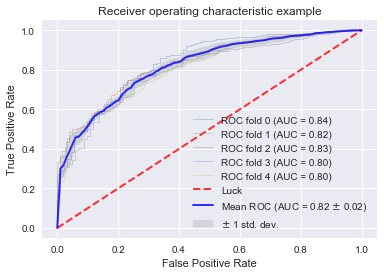

In [35]:
classifier = Pipeline([
    ("scaler",MaxAbsScaler()),
    ("SVR",StackingEstimator(estimator=SVC())),
    ("RidgeCV",StackingEstimator(estimator=RidgeClassifierCV())),
    ("BaggingClassifier",BaggingClassifier(base_estimator=myStackingFeatures(),random_state=0))])

#clsssifer = myStackingFeatures()


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
N = 5
kf = KFold(n_splits=N, random_state=42)
count = 0

precision = np.zeros((N,))
recall = np.zeros((N,))

for train_index, test_index in kf.split(train_x):
    training_features, training_target, training_label = train_x[train_index], train_y[train_index], high_labels[train_index]
    testing_features, testing_target, testing_label = train_x[test_index], train_y[test_index], high_labels[test_index]
 
    probas_ = classifier.fit(training_features, training_label).predict_proba(testing_features)
 
    fpr, tpr, thresholds = roc_curve(testing_label, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (count, roc_auc))

    count += 1  
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")


print("Precision: %1.3f" % precision.mean())
print("Recall: %1.3f" % recall.mean())


plt.show()